In [1]:
#libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
# Pickle it for later use
import pickle
sns.set()

In [2]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# stop fuzzy charts
%config InlineBackend.figure_format = "retina"

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity ='all'

In [5]:
df_fertiliser =  pd.read_pickle("../data/df_fertiliser.pkl")  
#new variables
df_all =  pd.read_pickle("../data/df_all.pkl")  
#tweets
df_tweets= pd.read_csv("../data/farmtweets.csv")   #farm tweets

### Removing outliers

def is_outlier(s):
    lower_limit = s.mean() - (s.std() * 3)
    upper_limit = s.mean() + (s.std() * 3)
    return ~s.between(lower_limit, upper_limit)

df_all = df_all[~df_all.groupby('fertiliser_type')['fertiliser_price'].apply(is_outlier)]
#df_all.groupby('fertiliser_type')['fertiliser_price'].describe()

In [6]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1720 entries, 10080 to 12143
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1720 non-null   datetime64[ns]
 1   fertiliser_type       1720 non-null   category      
 2   fertiliser_price      1720 non-null   float64       
 3   month_year            1720 non-null   period[M]     
 4   month                 1720 non-null   category      
 5   year                  1720 non-null   category      
 6   phosphate_price       1720 non-null   float64       
 7   urea_price            1720 non-null   float64       
 8   milk_price            1720 non-null   float64       
 9   gas_price             1720 non-null   float64       
 10  potassium_price       1720 non-null   float64       
 11  consumer_price_index  1720 non-null   float64       
dtypes: category(3), datetime64[ns](1), float64(7), period[M](1)
memory usag

In [7]:
df_all.shape

(1720, 12)

In [8]:
#df_all

In [9]:
#df_urea= df_all[df_all.fertiliser_type == "Calcium Ammonium Nitrate (27.5% N)"]

In [10]:
#keep date, fertiliser_type, month_year, month, year
X_new= df_all.drop(['fertiliser_price'], axis=1) # feature matrix 
feature_name = X_new.columns
y_new = df_all['fertiliser_price']
class_labels = np.unique(y_new)

### Encoding the data

In [11]:
import category_encoders as ce

# columns to encode 
encoder = ce.OrdinalEncoder(cols=['month_year', 
                                  'fertiliser_type',
                                  'month', 
                                  'year', 'date'])

X_new = encoder.fit_transform(X_new)
#X_new
#X_new. iloc[:, [0,1,2, 3, 4]]

### One hot encoding 

In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

#columns to one hot encode
ct = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(categories='auto'), [0, 1, 2, 3, 4])],   # The column numbers to be transformed (here is [0] but can be [0, 1, 3])
    remainder='passthrough'                                         # Leave the rest of the columns untouched
)

X_new =ct.fit_transform(X_new)


###  Split data into test and train

In [13]:
from sklearn.model_selection import train_test_split # Import train_test_split function [2]
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.33, random_state=42) # 67% training and 33% test // found out by 1 - test_size = 1 - 0.33 = 0.67 -> 67%
X_train.shape, X_test.shape

((1152, 218), (568, 218))

## Standard Scaler
had to use with mean false

In [14]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler(with_mean=False)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Linear regression

In [15]:
# Training the Multiple Linear Regression model on the Training set
#This is the same code we used in Simple Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

regr = LinearRegression()
regr.fit(X_train, y_train)

LinearRegression()

#### Predictions

In [16]:
#y_test
#X_test
y_pred = regr.predict(X_test)

In [17]:
df=pd.DataFrame({'Input':X_test, 'Actual':y_test, 'Predicted':y_pred})
df.head()

,Input,Actual,Predicted
10799,"(0, 29)\t11.358163320526257\n (0, 105)\t4.3...",324.0,323.834074
11897,"(0, 75)\t8.821178640756415\n (0, 100)\t4.68...",393.0,401.474391
10218,"(0, 5)\t9.849392180017482\n (0, 101)\t4.465...",424.0,433.316570
10242,"(0, 6)\t8.544827938995745\n (0, 101)\t4.465...",421.0,433.166546
10487,"(0, 16)\t9.467143082050507\n (0, 105)\t4.36...",362.0,355.553504


#### Evaluation of Linear Regression model

In [18]:
#We calculate the precision of the model or r^2
print('The precision of the model is ')
print(regr.score(X_train, y_train))
#0.43271583296060845
#added inflation - 0.4354100616894637
#one hot encoding - 0.8815790041207024

The precision of the model is 
0.8947500197857304


In [19]:
import math 

# The mean absolute error - doesn't say if it is too high or low
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,y_pred))

# The mean squared error
model_mse = mean_squared_error(y_test,y_pred)

print("Mean squared error: %.2f" % model_mse)

model_rmse = math.sqrt(model_mse)
# The root mean squared error
print("Root mean squared error: %.2f" % model_rmse)

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test,y_pred))

Mean absolute error: 14.24
Mean squared error: 689.98
Root mean squared error: 26.27
Coefficient of determination: 0.90


In [23]:
# The coefficients

#regr.intercept_
#regr.coef_[0]

<Figure size 1440x360 with 0 Axes>

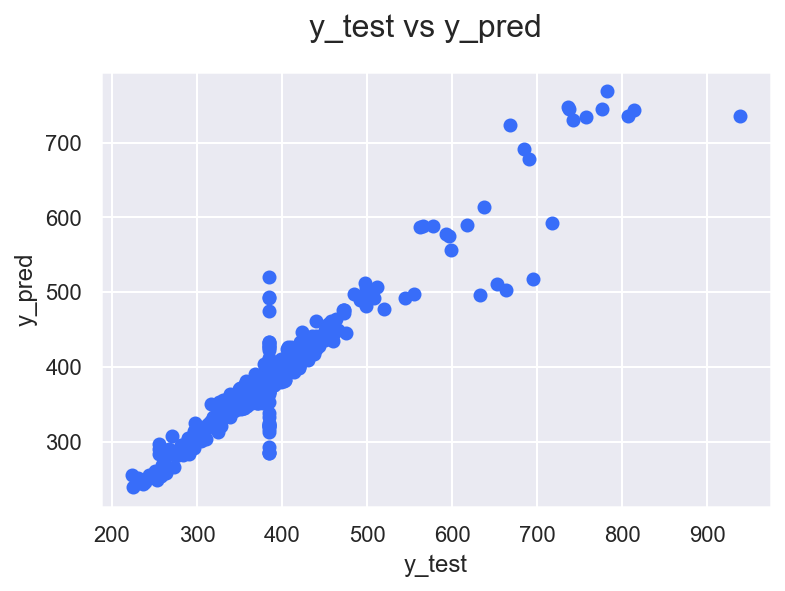

In [24]:
#EVALUATION OF THE MODEL
# Plotting y_test and y_pred to understand the spread.
#set to seaborn
sns.set()
#palette
sns.set_palette('rainbow');
#plot size
plt.figure(figsize=(20, 5));  

fig = plt.figure()
plt.scatter(y_test,y_pred);

fig.suptitle('y_test vs y_pred', fontsize=16);              # Plot heading 
plt.xlabel('y_test');                         # X-label
plt.ylabel('y_pred');   

In [ ]:
np.argmax(ohe_encoded, axis = 1)

In [41]:
coef = pd.Series(regr.coef_)
coef

0       0.440688
1       0.155832
2       0.477813
3       0.937146
4       1.262147
         ...    
213    10.277792
214     3.477436
215     3.122197
216     5.467292
217     5.993590
Length: 218, dtype: float64

## Lasso

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso

# function to get cross validation scores
def get_cv_scores(model):
    scores = cross_val_score(model,
                             X_train,
                             y_train,
                             cv=5,
                             scoring='r2')
    
    print('CV Mean: ', np.mean(scores))
    print('STD: ', np.std(scores))
    print('\n')
    

In [23]:
# Train model with default alpha=1
lasso = Lasso(alpha=1).fit(X_train, y_train)
# get cross val scores
#get_cv_scores(lasso)

print('The precision of the model is ', lasso.score(X_train, y_train))
print('\n')
get_cv_scores(lasso)
#inflation - 0.429963165407963
#onehot encoding - 0.8627252790023363

The precision of the model is  0.8857829890167587


CV Mean:  0.8625651086782465
STD:  0.045125863124525586




#### Predictions for Lasso

In [24]:
y_pred = lasso.predict(X_test)

In [25]:
df=pd.DataFrame({'Input':X_test, 'Actual':y_test, 'Predicted':y_pred})
df.head()

,Input,Actual,Predicted
10799,"(0, 29)\t11.358163320526257\n (0, 105)\t4.3...",324.0,328.846134
11897,"(0, 75)\t8.821178640756415\n (0, 100)\t4.68...",393.0,390.796372
10218,"(0, 5)\t9.849392180017482\n (0, 101)\t4.465...",424.0,425.646495
10242,"(0, 6)\t8.544827938995745\n (0, 101)\t4.465...",421.0,428.928333
10487,"(0, 16)\t9.467143082050507\n (0, 105)\t4.36...",362.0,361.683229


In [26]:
import math 

# The mean absolute error - doesn't say if it is too high or low
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,y_pred))

# The mean squared error
model_mse = mean_squared_error(y_test,y_pred)

print("Mean squared error: %.2f" % model_mse)

model_rmse = math.sqrt(model_mse)
# The root mean squared error
print("Root mean squared error: %.2f" % model_rmse)

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test,y_pred))

Mean absolute error: 15.87
Mean squared error: 741.97
Root mean squared error: 27.24
Coefficient of determination: 0.89


## Ridge

In [27]:
from sklearn.linear_model import Ridge
# Train model with default alpha=1
ridge = Ridge(alpha=1).fit(X_train, y_train)
# get cross val scores
get_cv_scores(ridge)
print('The precision of the model is ', ridge.score(X_train, y_train))
#onehot encoding - 0.881578260923781

CV Mean:  0.866801047468171
STD:  0.047712606656912786


The precision of the model is  0.8947479835332938


In [28]:
y_pred = ridge.predict(X_test)

In [29]:
df=pd.DataFrame({'Input':X_test, 'Actual':y_test, 'Predicted':y_pred})
df.head()

,Input,Actual,Predicted
10799,"(0, 29)\t11.358163320526257\n (0, 105)\t4.3...",324.0,323.878074
11897,"(0, 75)\t8.821178640756415\n (0, 100)\t4.68...",393.0,401.394728
10218,"(0, 5)\t9.849392180017482\n (0, 101)\t4.465...",424.0,433.227489
10242,"(0, 6)\t8.544827938995745\n (0, 101)\t4.465...",421.0,433.045358
10487,"(0, 16)\t9.467143082050507\n (0, 105)\t4.36...",362.0,355.533465


In [30]:
import math 

# The mean absolute error - doesn't say if it is too high or low
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,y_pred))

# The mean squared error
model_mse = mean_squared_error(y_test,y_pred)

print("Mean squared error: %.2f" % model_mse)

model_rmse = math.sqrt(model_mse)
# The root mean squared error
print("Root mean squared error: %.2f" % model_rmse)

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test,y_pred))

Mean absolute error: 14.24
Mean squared error: 690.19
Root mean squared error: 26.27
Coefficient of determination: 0.90


### ElasticNet

In [31]:
from sklearn.linear_model import ElasticNet
# Train model with default alpha=1 and l1_ratio=0.5
elastic_net = ElasticNet(alpha=1, l1_ratio=0.5).fit(X_train, y_train)
# get cross val scores
get_cv_scores(elastic_net)
print('The precision of the model is ', elastic_net.score(X_train, y_train))
# onehot encoding 0.8095062920374447

CV Mean:  0.8286966453798671
STD:  0.03845829441416415


The precision of the model is  0.8563019244881933


In [32]:
y_pred = elastic_net.predict(X_test)

In [33]:
df=pd.DataFrame({'Input':X_test, 'Actual':y_test, 'Predicted':y_pred})
df.head()

,Input,Actual,Predicted
10799,"(0, 29)\t11.358163320526257\n (0, 105)\t4.3...",324.0,337.133965
11897,"(0, 75)\t8.821178640756415\n (0, 100)\t4.68...",393.0,392.155235
10218,"(0, 5)\t9.849392180017482\n (0, 101)\t4.465...",424.0,421.624995
10242,"(0, 6)\t8.544827938995745\n (0, 101)\t4.465...",421.0,418.911412
10487,"(0, 16)\t9.467143082050507\n (0, 105)\t4.36...",362.0,360.400447


In [34]:
import math 

# The mean absolute error - doesn't say if it is too high or low
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,y_pred))

# The mean squared error
model_mse = mean_squared_error(y_test,y_pred)

print("Mean squared error: %.2f" % model_mse)

model_rmse = math.sqrt(model_mse)
# The root mean squared error
print("Root mean squared error: %.2f" % model_rmse)

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test,y_pred))

Mean absolute error: 20.23
Mean squared error: 1031.63
Root mean squared error: 32.12
Coefficient of determination: 0.85


## Grid search

Tuning hyperparameters for the ML algorithms

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [36]:
#ElasticNet().get_params().keys()

In [37]:
#LinearRegression().get_params().keys()

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# create a dictionary for the models and the parameters
model_params = {
    'LinearRegression': {
        'model': LinearRegression(),   # Linear regression
        'params' : {
            "fit_intercept": [True, False],
          #  "normalize": [0,1],
          #  "positive": [True, False]
            
        }
    },
      'Lasso': {
        'model': Lasso(),   # Lasso 
        'params' : {
            "alpha": [0,10,50,100],
            "fit_intercept": [True, False],
            "normalize": [0,1],
            "positive": [True, False]
            
        }
    },
     'Ridge': {
        'model': Ridge(),   # Ridge 
        'params' : {
            "alpha": [0,10,50,100],
            "fit_intercept": [True, False],
            "normalize": [0,1],
            "positive": [True, False],
            "solver":['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
            
        }
    },
    'Elastic Net': {
        'model': ElasticNet(),   # ElasticNet 
        'params' : {
            "alpha": [0,10,50,100],
            "fit_intercept": [True, False],
            "normalize": [0,1],
            "positive": [True, False]
            
        }
    }
 
}

In [39]:
#create a dataframe
scores = []


for model_name, mp in model_params.items():
    # create classifier with model and parameters
    clf =  GridSearchCV(mp['model'], mp['params'], cv=10, return_train_score=False)
    #fit to the model
    clf.fit(X_train,y_train)
    # add score into the dataset
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'results': clf.cv_results_
    })
    
df_grid_search = pd.DataFrame(scores,columns=['model', 'best_score', 'best_params','results'])
#stop cutting off text in column
pd.set_option('display.max_colwidth', -1)

#view table
df_grid_search

GridSearchCV(cv=10, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False]})

GridSearchCV(cv=10, estimator=Lasso(),
             param_grid={'alpha': [0, 10, 50, 100],
                         'fit_intercept': [True, False], 'normalize': [0, 1],
                         'positive': [True, False]})

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': [0, 10, 50, 100],
                         'fit_intercept': [True, False], 'normalize': [0, 1],
                         'positive': [True, False],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag', 'saga', 'lbfgs']})

GridSearchCV(cv=10, estimator=ElasticNet(),
             param_grid={'alpha': [0, 10, 50, 100],
                         'fit_intercept': [True, False], 'normalize': [0, 1],
                         'positive': [True, False]})

model  best_score  \
0  LinearRegression  0.860017     
1  Lasso             0.860017     
2  Ridge             0.860159     
3  Elastic Net       0.860017     

                                                                                  best_params  \
0  {'fit_intercept': False}                                                                     
1  {'alpha': 0, 'fit_intercept': False, 'normalize': 0, 'positive': False}                      
2  {'alpha': 10, 'fit_intercept': False, 'normalize': 0, 'positive': False, 'solver': 'saga'}   
3  {'alpha': 0, 'fit_intercept': False, 'normalize': 0, 'positive': False}                      

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

### PCA

## Neural Network

In [40]:
#libraries to install
#!pip install tensorflow

In [83]:
#!pip install keras

In [84]:
#!pip install scikit-learn

In [95]:
# neural network with keras tutorial
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [96]:
X_train.shape

(1119, 218)

In [97]:
ann = Sequential([
    Dense(32, activation='relu', input_shape=(218,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])
# compile the keras model
ann.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'mse'])
# fit the keras model on the dataset
ann.fit(X_train, y_train, epochs=350, batch_size=100)
# evaluate the keras model
_, accuracy, mse = ann.evaluate(X_train, y_train)
print('Accuracy: %.2f' % (accuracy*100))

2022-05-15 11:45:15.467429: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-15 11:45:15.467728: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/350
1119/1119 [==============================] - 1s 663us/step - loss: -260.6793 - accuracy: 0.0000e+00 - mse: 142577.1562
Epoch 2/350
1119/1119 [==============================] - 0s 49us/step - loss: -1210.7774 - accuracy: 0.0000e+00 - mse: 142355.2188
Epoch 3/350
1119/1119 [==============================] - 0s 49us/step - loss: -2451.4805 - accuracy: 0.0000e+00 - mse: 142311.7500
Epoch 4/350
1119/1119 [==============================] - 0s 48us/step - loss: -4372.8333 - accuracy: 0.0000e+00 - mse: 142308.2344
Epoch 5/350
1119/1119 [==============================] - 0s 54us/step - loss: -7485.5163 - accuracy: 0.0000e+00 - mse: 142308.1562
Epoch 6/350
1119/1119 [==============================] - 0s 49us/step - loss: -12513.9608 - accuracy: 0.0000e+00 - mse: 142308.1562
Epoch 7/350
1119/1119 [==============================] - 0s 47us/step - loss: -20159.6153 - accuracy: 0.0000e+00 - mse: 142308.1562
Epoch 8/350
1119/1119 [==============================] - 0s 45us/step - loss: -31

1119/1119 [==============================] - 0s 43us/step - loss: -24860101.0867 - accuracy: 0.0000e+00 - mse: 142308.1562
Epoch 62/350
1119/1119 [==============================] - 0s 43us/step - loss: -26089539.5961 - accuracy: 0.0000e+00 - mse: 142308.1562
Epoch 63/350
1119/1119 [==============================] - 0s 46us/step - loss: -27358908.8275 - accuracy: 0.0000e+00 - mse: 142308.1562
Epoch 64/350
1119/1119 [==============================] - 0s 45us/step - loss: -28661397.1939 - accuracy: 0.0000e+00 - mse: 142308.1562
Epoch 65/350
1119/1119 [==============================] - 0s 46us/step - loss: -30006338.3557 - accuracy: 0.0000e+00 - mse: 142308.1562
Epoch 66/350
1119/1119 [==============================] - 0s 46us/step - loss: -31391963.2368 - accuracy: 0.0000e+00 - mse: 142308.1562
Epoch 67/350
1119/1119 [==============================] - 0s 46us/step - loss: -32812963.3673 - accuracy: 0.0000e+00 - mse: 142308.1562
Epoch 68/350
1119/1119 [==============================] - 0s 

1119/1119 [==============================] - 0s 47us/step - loss: -177072924.4969 - accuracy: 0.0000e+00 - mse: 142308.1406
Epoch 122/350
1119/1119 [==============================] - 0s 47us/step - loss: -181141793.4441 - accuracy: 0.0000e+00 - mse: 142308.1406
Epoch 123/350
1119/1119 [==============================] - 0s 48us/step - loss: -185253042.6881 - accuracy: 0.0000e+00 - mse: 142308.1406
Epoch 124/350
1119/1119 [==============================] - 0s 54us/step - loss: -189416438.2484 - accuracy: 0.0000e+00 - mse: 142308.1562
Epoch 125/350
1119/1119 [==============================] - 0s 53us/step - loss: -193665102.6130 - accuracy: 0.0000e+00 - mse: 142308.1406
Epoch 126/350
1119/1119 [==============================] - 0s 52us/step - loss: -197944270.0554 - accuracy: 0.0000e+00 - mse: 142308.1562
Epoch 127/350
1119/1119 [==============================] - 0s 51us/step - loss: -202284049.8874 - accuracy: 0.0000e+00 - mse: 142308.1719
Epoch 128/350
1119/1119 [=======================

1119/1119 [==============================] - 0s 45us/step - loss: -516561327.6711 - accuracy: 0.0000e+00 - mse: 142308.1562
Epoch 181/350
1119/1119 [==============================] - 0s 45us/step - loss: -524169655.7927 - accuracy: 0.0000e+00 - mse: 142308.1406
Epoch 182/350
1119/1119 [==============================] - 0s 47us/step - loss: -531791996.5970 - accuracy: 0.0000e+00 - mse: 142308.1562
Epoch 183/350
1119/1119 [==============================] - 0s 45us/step - loss: -539552823.7069 - accuracy: 0.0000e+00 - mse: 142308.1406
Epoch 184/350
1119/1119 [==============================] - 0s 46us/step - loss: -547324434.8168 - accuracy: 0.0000e+00 - mse: 142308.1562
Epoch 185/350
1119/1119 [==============================] - 0s 46us/step - loss: -555192885.7623 - accuracy: 0.0000e+00 - mse: 142308.1406
Epoch 186/350
1119/1119 [==============================] - 0s 46us/step - loss: -563101906.5308 - accuracy: 0.0000e+00 - mse: 142308.1562
Epoch 187/350
1119/1119 [=======================

1119/1119 [==============================] - 0s 44us/step - loss: -1077961149.1403 - accuracy: 0.0000e+00 - mse: 142308.1562
Epoch 240/350
1119/1119 [==============================] - 0s 45us/step - loss: -1089486061.5836 - accuracy: 0.0000e+00 - mse: 142308.1719
Epoch 241/350
1119/1119 [==============================] - 0s 45us/step - loss: -1101089845.4191 - accuracy: 0.0000e+00 - mse: 142308.1562
Epoch 242/350
1119/1119 [==============================] - 0s 45us/step - loss: -1112814134.6774 - accuracy: 0.0000e+00 - mse: 142308.1406
Epoch 243/350
1119/1119 [==============================] - 0s 45us/step - loss: -1124570565.3762 - accuracy: 0.0000e+00 - mse: 142308.1562
Epoch 244/350
1119/1119 [==============================] - 0s 46us/step - loss: -1136437511.2064 - accuracy: 0.0000e+00 - mse: 142308.1719
Epoch 245/350
1119/1119 [==============================] - 0s 45us/step - loss: -1148345330.2735 - accuracy: 0.0000e+00 - mse: 142308.1562
Epoch 246/350
1119/1119 [================

1119/1119 [==============================] - 0s 49us/step - loss: -1883633757.4549 - accuracy: 0.0000e+00 - mse: 142308.1562
Epoch 299/350
1119/1119 [==============================] - 0s 46us/step - loss: -1899532796.6828 - accuracy: 0.0000e+00 - mse: 142308.1562
Epoch 300/350
1119/1119 [==============================] - 0s 48us/step - loss: -1915518252.2681 - accuracy: 0.0000e+00 - mse: 142308.1562
Epoch 301/350
1119/1119 [==============================] - 0s 48us/step - loss: -1931565710.7560 - accuracy: 0.0000e+00 - mse: 142308.1406
Epoch 302/350
1119/1119 [==============================] - 0s 46us/step - loss: -1947673114.4236 - accuracy: 0.0000e+00 - mse: 142308.1719
Epoch 303/350
1119/1119 [==============================] - 0s 46us/step - loss: -1963891172.0894 - accuracy: 0.0000e+00 - mse: 142308.1562
Epoch 304/350
1119/1119 [==============================] - 0s 48us/step - loss: -1980153848.1072 - accuracy: 0.0000e+00 - mse: 142308.1562
Epoch 305/350
1119/1119 [================

1119/1119 [==============================] - 0s 184us/step
Accuracy: 0.00


first round - batch size - 10, accuracy = 0%, ReLU
second round - batch size = 50, accuracy = 0%, ReLU

### Time series analysis with ARIMA

In [23]:
from statsmodels.tsa.arima_model import ARMA

In [24]:
df_fertiliser.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6557 entries, 0 to 12143
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   statistic        6557 non-null   object        
 1   date             6557 non-null   datetime64[ns]
 2   fertiliser_type  6557 non-null   category      
 3   unit             6557 non-null   object        
 4   value            6557 non-null   float64       
 5   month_year       6557 non-null   period[M]     
 6   month            6557 non-null   int64         
 7   year             6557 non-null   int64         
dtypes: category(1), datetime64[ns](1), float64(1), int64(2), object(2), period[M](1)
memory usage: 416.4+ KB


In [25]:
#set the index
df_fertiliser.index =  df_fertiliser['date']

In [26]:
df_fertiliser

,statistic,date,fertiliser_type,unit,value,month_year,month,year
date,,,,,,,,
1980-01-01,Fertiliser Price,1980-01-01,Calcium Ammonium Nitrate (27.5% N),Euro per Tonne,121.0,1980-01,1,1980
1980-01-01,Fertiliser Price,1980-01-01,Urea (46% N),Euro per Tonne,144.0,1980-01,1,1980
1980-01-01,Fertiliser Price,1980-01-01,Granular Superphosphate (16% P),Euro per Tonne,160.0,1980-01,1,1980
1980-01-01,Fertiliser Price,1980-01-01,Muriate of Potash (50% K),Euro per Tonne,109.0,1980-01,1,1980
1980-01-01,Fertiliser Price,1980-01-01,Compound 0-10-20,Euro per Tonne,130.0,1980-01,1,1980
...,...,...,...,...,...,...,...,...
2022-02-01,Fertiliser Price,2022-02-01,Compound 13-6-20,Euro per Tonne,781.0,2022-02,2,2022
2022-02-01,Fertiliser Price,2022-02-01,Compound 15-3-20,Euro per Tonne,770.0,2022-02,2,2022
2022-02-01,Fertiliser Price,2022-02-01,Compound 24-2.2-4.5,Euro per Tonne,748.0,2022-02,2,2022


In [27]:

#df_fertiliser_year = df_fertiliser[(df_fertiliser["date"] > datefrom & df_fertiliser["date"] < dateTo )]

start_date = '2008-02-01'
end_date = '2022-02-01'

df_oneyear = df_fertiliser[(df_fertiliser['date'] > start_date) & (df_fertiliser['date'] <= end_date)]
df_oneyear

,statistic,date,fertiliser_type,unit,value,month_year,month,year
date,,,,,,,,
2008-03-01,Fertiliser Price,2008-03-01,Calcium Ammonium Nitrate (27.5% N),Euro per Tonne,354.0,2008-03,3,2008
2008-03-01,Fertiliser Price,2008-03-01,Urea (46% N),Euro per Tonne,422.0,2008-03,3,2008
2008-03-01,Fertiliser Price,2008-03-01,Granular Superphosphate (16% P),Euro per Tonne,517.0,2008-03,3,2008
2008-03-01,Fertiliser Price,2008-03-01,Muriate of Potash (50% K),Euro per Tonne,430.0,2008-03,3,2008
2008-03-01,Fertiliser Price,2008-03-01,Compound 0-10-20,Euro per Tonne,410.0,2008-03,3,2008
...,...,...,...,...,...,...,...,...
2022-02-01,Fertiliser Price,2022-02-01,Compound 13-6-20,Euro per Tonne,781.0,2022-02,2,2022
2022-02-01,Fertiliser Price,2022-02-01,Compound 15-3-20,Euro per Tonne,770.0,2022-02,2,2022
2022-02-01,Fertiliser Price,2022-02-01,Compound 24-2.2-4.5,Euro per Tonne,748.0,2022-02,2,2022


<Figure size 1152x504 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Fertiliser Price')

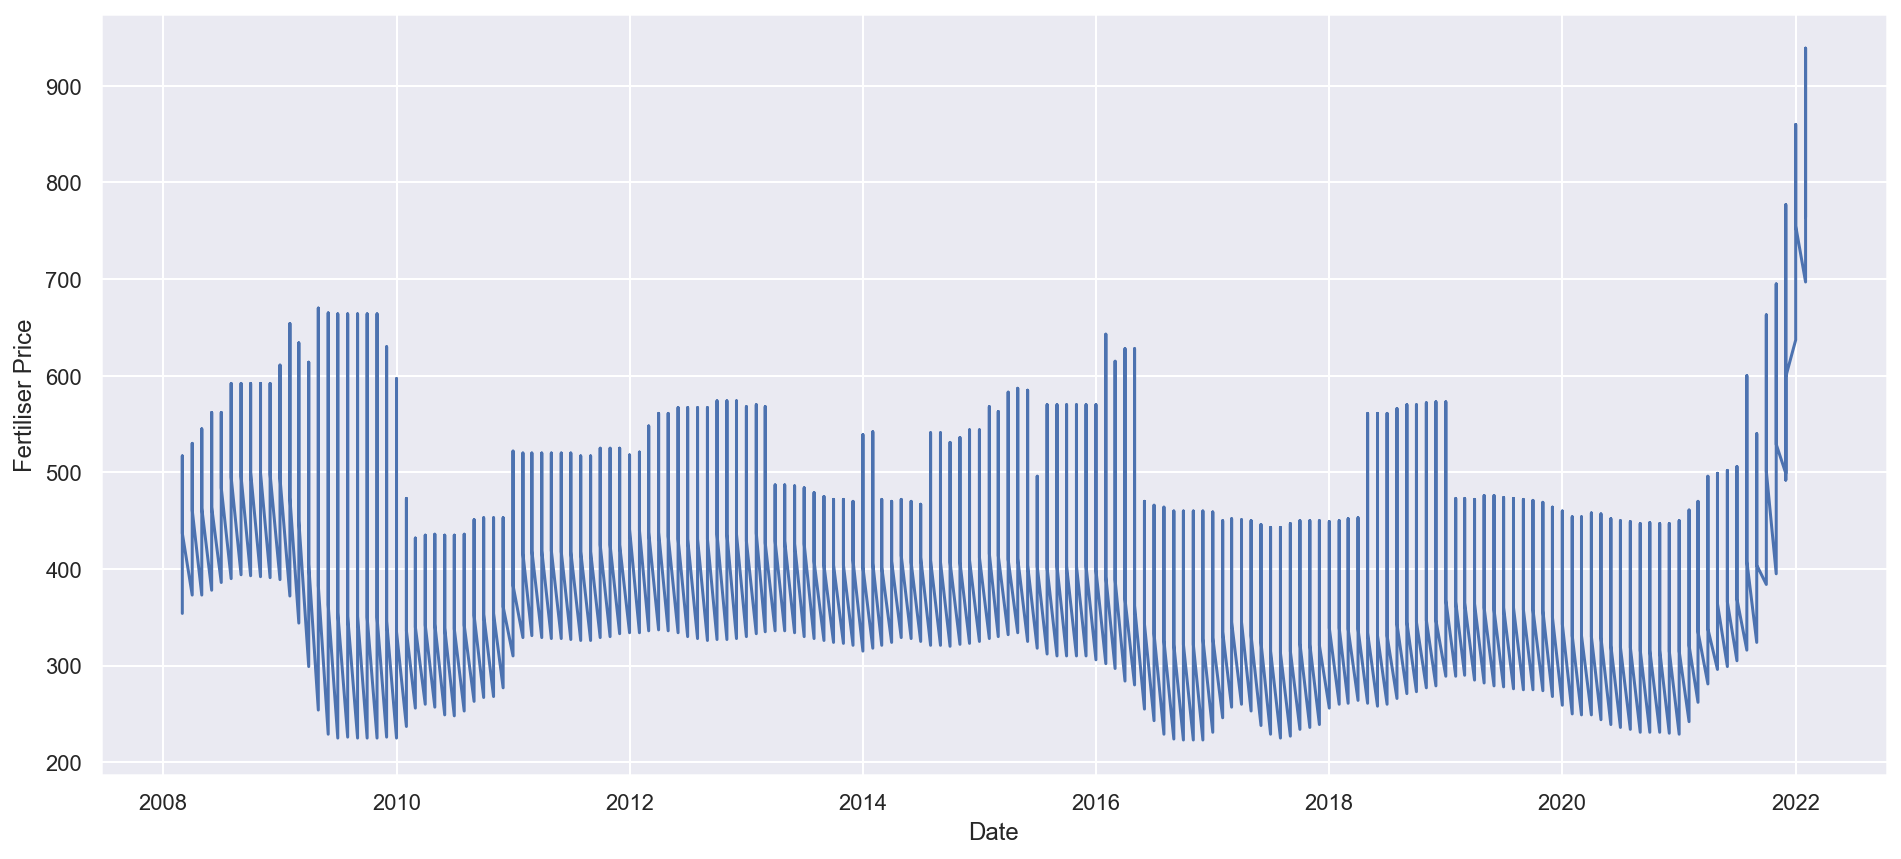

In [28]:
#Data Exploration
plt.figure(figsize=(16,7))
fig = plt.figure(1)
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Date')
ax1.set_ylabel('Fertiliser Price')
ax1.plot(df_oneyear['value'])

<Figure size 1152x504 with 0 Axes>

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

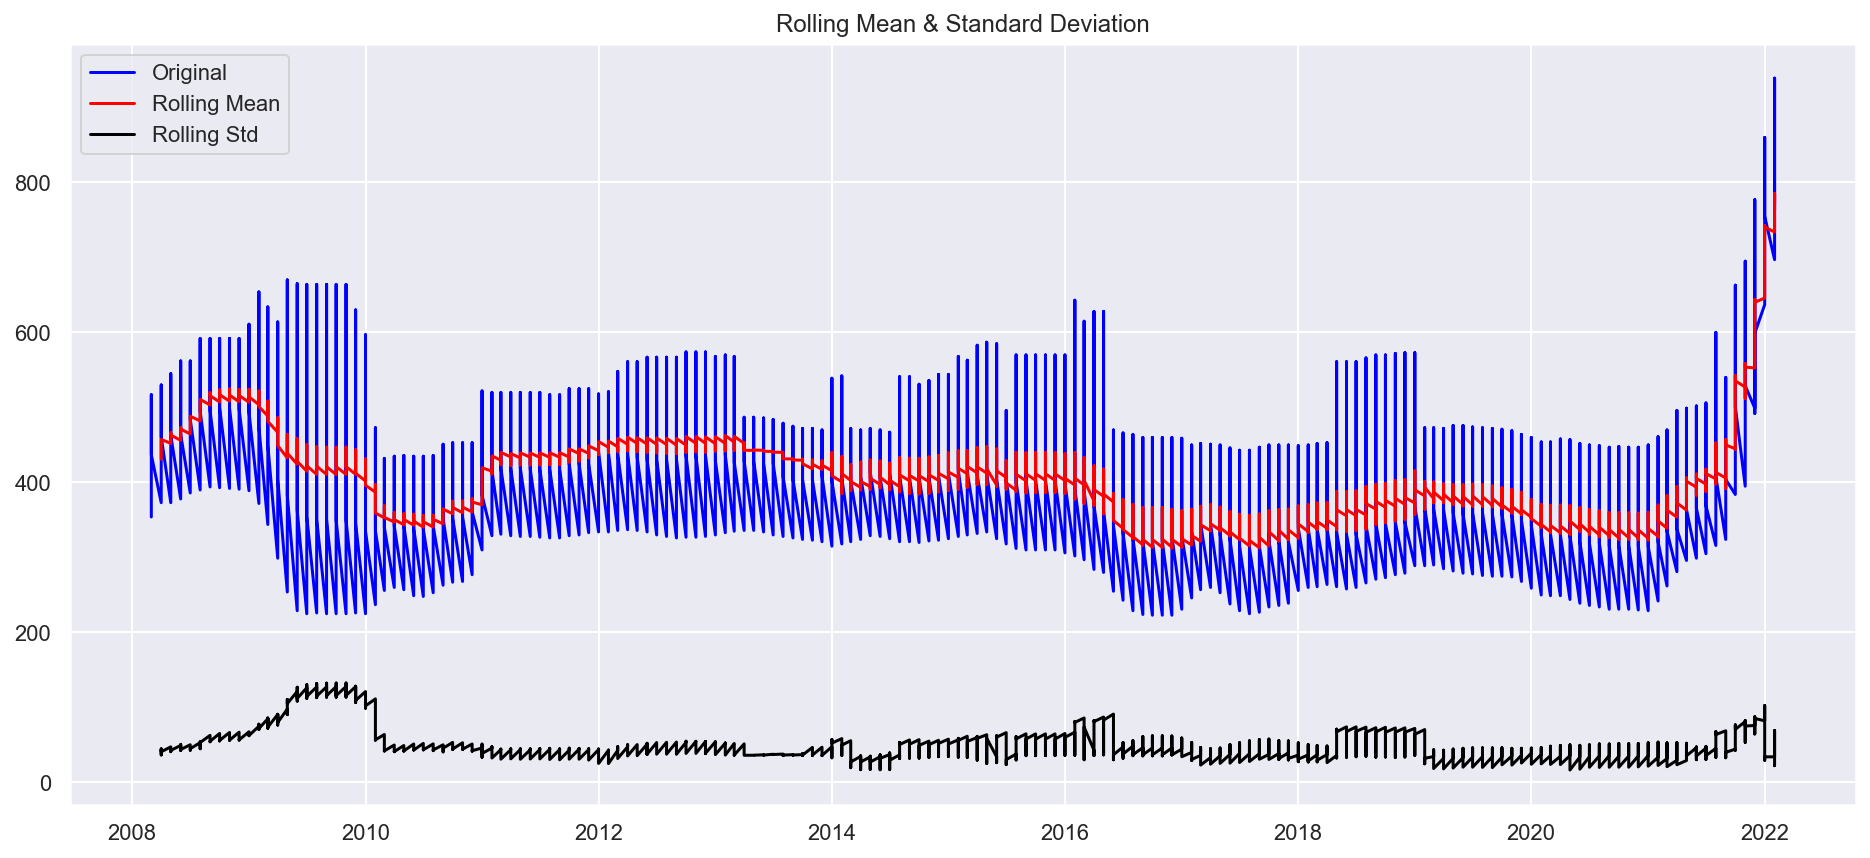

In [29]:
#Determing rolling statistics
rolLmean = df_oneyear['value'].rolling(12).mean()
rolLstd = df_oneyear['value'].rolling(12).std()

plt.figure(figsize=(16,7))
fig = plt.figure(1)

#Plot rolling statistics:
orig = plt.plot(df_oneyear['value'], color='blue',label='Original')
mean = plt.plot(rolLmean, color='red', label='Rolling Mean')
std = plt.plot(rolLstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

<Figure size 1152x504 with 0 Axes>

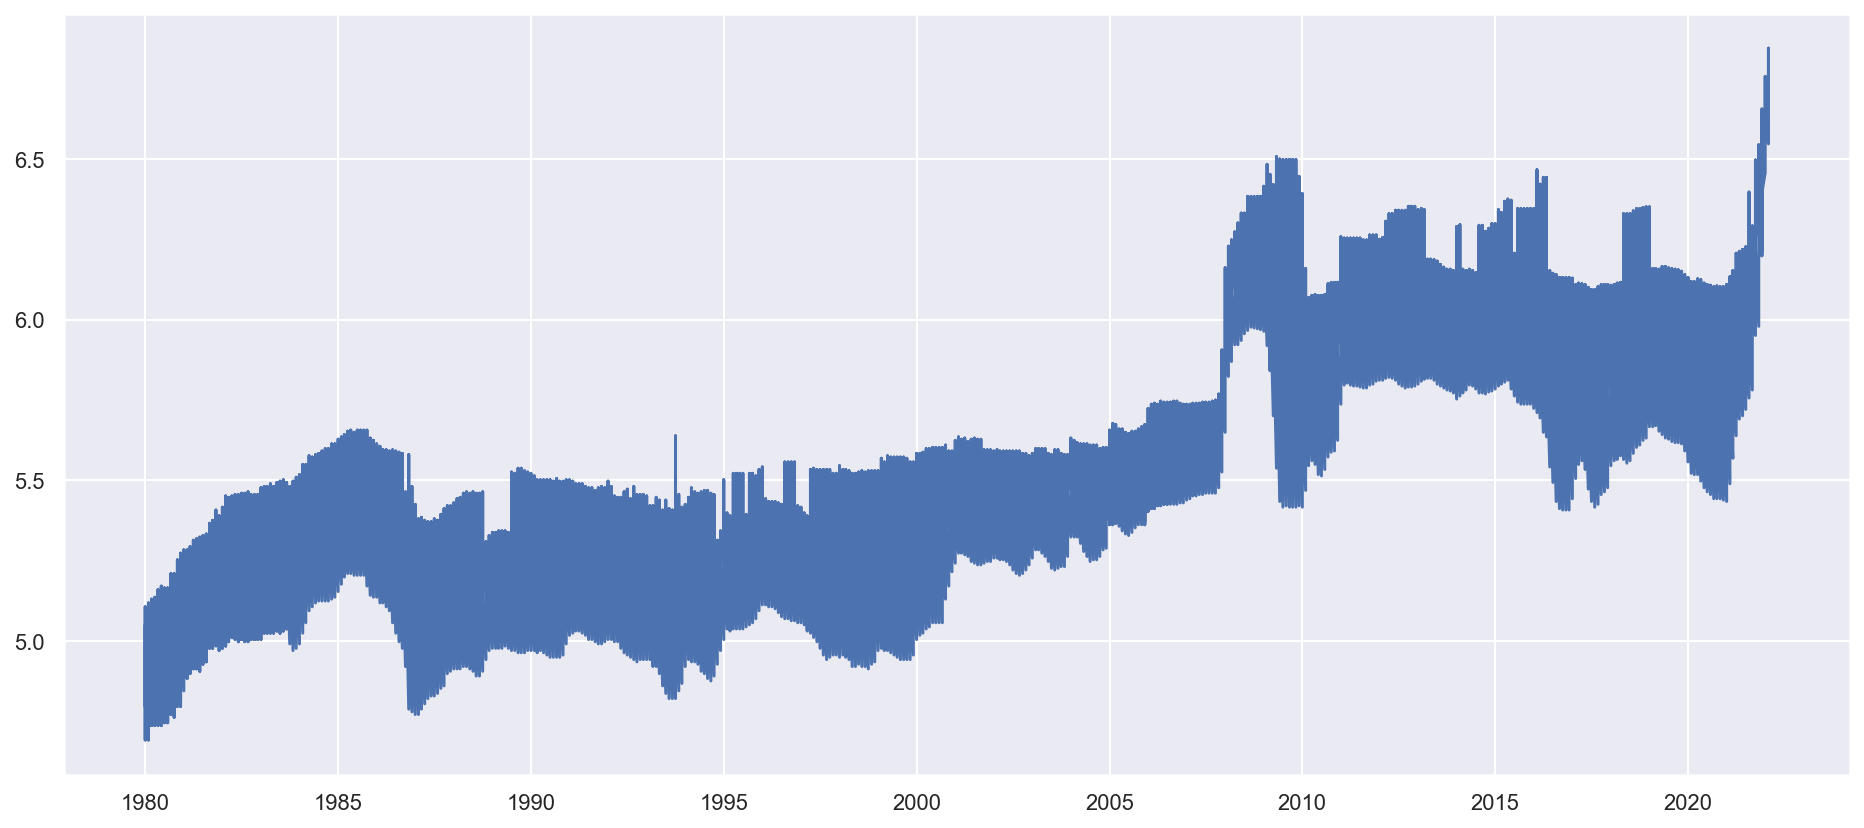

In [30]:
#Lets try transformation
plt.figure(figsize=(16,7))
fig = plt.figure(1)

import numpy as np
ts_log = np.log(df_fertiliser['value'])
plt.plot(ts_log)

In [31]:
#Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, freq=1, model = 'multiplicative')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16,7))
fig = plt.figure(1)

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

TypeError: seasonal_decompose() got an unexpected keyword argument 'freq'

In [ ]:
#Lets try differencing
plt.figure(figsize=(16,7))
fig = plt.figure(1)
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

#Determing rolling statistics
rolLmean = ts_log_diff.rolling(12).mean()
rolLstd = ts_log_diff.rolling(12).std()




#Plot rolling statistics:
orig = plt.plot(ts_log_diff, color='blue',label='Original')
mean = plt.plot(rolLmean, color='red', label='Rolling Mean')
std = plt.plot(rolLstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
df_fertiliser.sort_index(inplace= True)

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20)

In [ ]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_log_diff.dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_log_diff.dropna(),lags=40,ax=ax2)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
type(ts_log_diff)

In [ ]:
#ts_log_diff.dropna()
ts_log_diff = ts_log_diff[~ts_log_diff.isnull()]

In [ ]:
plt.figure(figsize=(16,8))
#ts_log_diff.dropna(inplace=True)
model = ARIMA(ts_log_diff, order=(2,1,2))  
results_ARIMA = model.fit()  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')

In [ ]:
ARIMA_diff_predictions = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(ARIMA_diff_predictions.head())

In [ ]:
ARIMA_diff_predictions_cumsum = ARIMA_diff_predictions.cumsum()
print(ARIMA_diff_predictions_cumsum.head())

In [ ]:
ARIMA_log_prediction = pd.Series(ts_log.iloc[0], index=ts_log.index)
ARIMA_log_prediction = ARIMA_log_prediction.add(ARIMA_diff_predictions_cumsum,fill_value=0)
ARIMA_log_prediction.head()

In [ ]:
plt.figure(figsize=(12,8))
predictions_ARIMA = np.exp(ARIMA_log_prediction)
plt.plot(df_fertiliser['value'])
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-df_fertiliser['value'])**2)/len(df_fertiliser['value'])))

# Sentiment analysis of tweets

In [ ]:
df_tweets

In [ ]:
# convert to datetime
df_tweets['Datetime'] = pd.to_datetime(df_tweets['Datetime']).dt.date

In [ ]:
# convert the date column to date format
df_tweets['Datetime'] = df_tweets['Datetime'].apply(pd.to_datetime)
df_tweets.info()

In [ ]:
df_tweets = df_tweets[(df_tweets['Datetime'] > "2022-01-01") & (df_tweets['Datetime'] < "2022-04-29")]

In [ ]:
#get the word count of the tweet
df_tweets["word_count"] = df_tweets["Text"].apply(lambda x: len(str(x).split()))

In [ ]:
#get the word count of the tweet
df_tweets["char_count"] = df_tweets["Text"].str.len()

### Natural Language processing

### Topic modelling
https://www.youtube.com/watch?v=NYkbqzTlW3w
https://www.youtube.com/watch?v=VraAbgAoYSk

In [16]:
#https://www.nltk.org/
import nltk #natural langugage toolkit

In [17]:
#download stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ritaraher/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
from nltk.corpus import stopwords
#remove stopwords
stop = stopwords.words("english")

In [19]:
# counting stop words
#stop words
df_tweets["stopwords"]= df_tweets["Text"].apply(lambda x: len([x for x in x.split() if x in stop]))

In [20]:
#count hashtags
df_tweets["hashtag"]= df_tweets["Text"].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))

In [22]:
# Apply text cleaning techniques
import re
import string

def clean_text_round1(text):
    text = text.lower()                                              #lowercase
    text = re.sub('\[.*?\]', '', text)                               #remove the twitter handle
    text = re.sub('@[^\s]+', '', text)                               # remove text in square brackets
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  # remove punctuation
    text = re.sub('\w*\d\w*', '', text)                              #remove words containing numbers
    text = re.sub('\n', '', text)                                    # remove \n
    return text

round1 = lambda x: clean_text_round1(x)

In [23]:
# Let's take a look at the updated text
df_tweets['tweet_clean'] = df_tweets.Text.apply(round1)
df_tweets

,Unnamed: 0,Datetime,Tweet Id,Text,word_count,char_count,stopwords,hashtag,tweet_clean
0,0,2022-04-27,1519235527324712960,‘Surging input costs are keeping #farmers awak...,17,139,2,3,‘surging input costs are keeping farmers awake...
1,1,2022-04-02,1510305024081117190,@jerwaugh @youngsiward Would you not agree tha...,44,259,20,0,would you not agree that if you owned a wind...
2,2,2022-02-27,1497968564069879813,@libraryturner @lidl_ireland Don’t get used to...,28,169,9,0,don’t get used to it costs are rising to muc...


In [24]:
#removing stop words from tweet clean
df_tweets["tweet_clean"]= df_tweets["tweet_clean"].apply(lambda x : " ".join(x for x in x.split() if x not in stop))

### Sentiment Analysis with TextBlob

In [25]:
##semantic analysis
from textblob import TextBlob
df_tweets["tweet_clean"][:5].apply(lambda x : TextBlob(x).sentiment)

#   (-0.5, 1.0)
# sentiment of being negative because of the -, subjective

0                                   (0.0, 0.0)
1    (0.05333333333333334, 0.6133333333333334)
2                                   (0.1, 0.6)
Name: tweet_clean, dtype: object

In [26]:
df_tweets["polarity"]= df_tweets["tweet_clean"].apply(lambda x : TextBlob(x).sentiment[0])

#   (-0.5, 1.0)
# sentiment of being negative because of the -, subjective

In [27]:
df_tweets["subjectivity"]= df_tweets["tweet_clean"].apply(lambda x : TextBlob(x).sentiment[1])

In [28]:
df_tweets

,Unnamed: 0,Datetime,Tweet Id,Text,word_count,char_count,stopwords,hashtag,tweet_clean,polarity,subjectivity
0,0,2022-04-27,1519235527324712960,‘Surging input costs are keeping #farmers awak...,17,139,2,3,‘surging input costs keeping farmers awake nig...,0.000000,0.000000
1,1,2022-04-02,1510305024081117190,@jerwaugh @youngsiward Would you not agree tha...,44,259,20,0,would agree owned wind farm ccgt would making ...,0.053333,0.613333
2,2,2022-02-27,1497968564069879813,@libraryturner @lidl_ireland Don’t get used to...,28,169,9,0,don’t get used costs rising much farm level it...,0.100000,0.600000


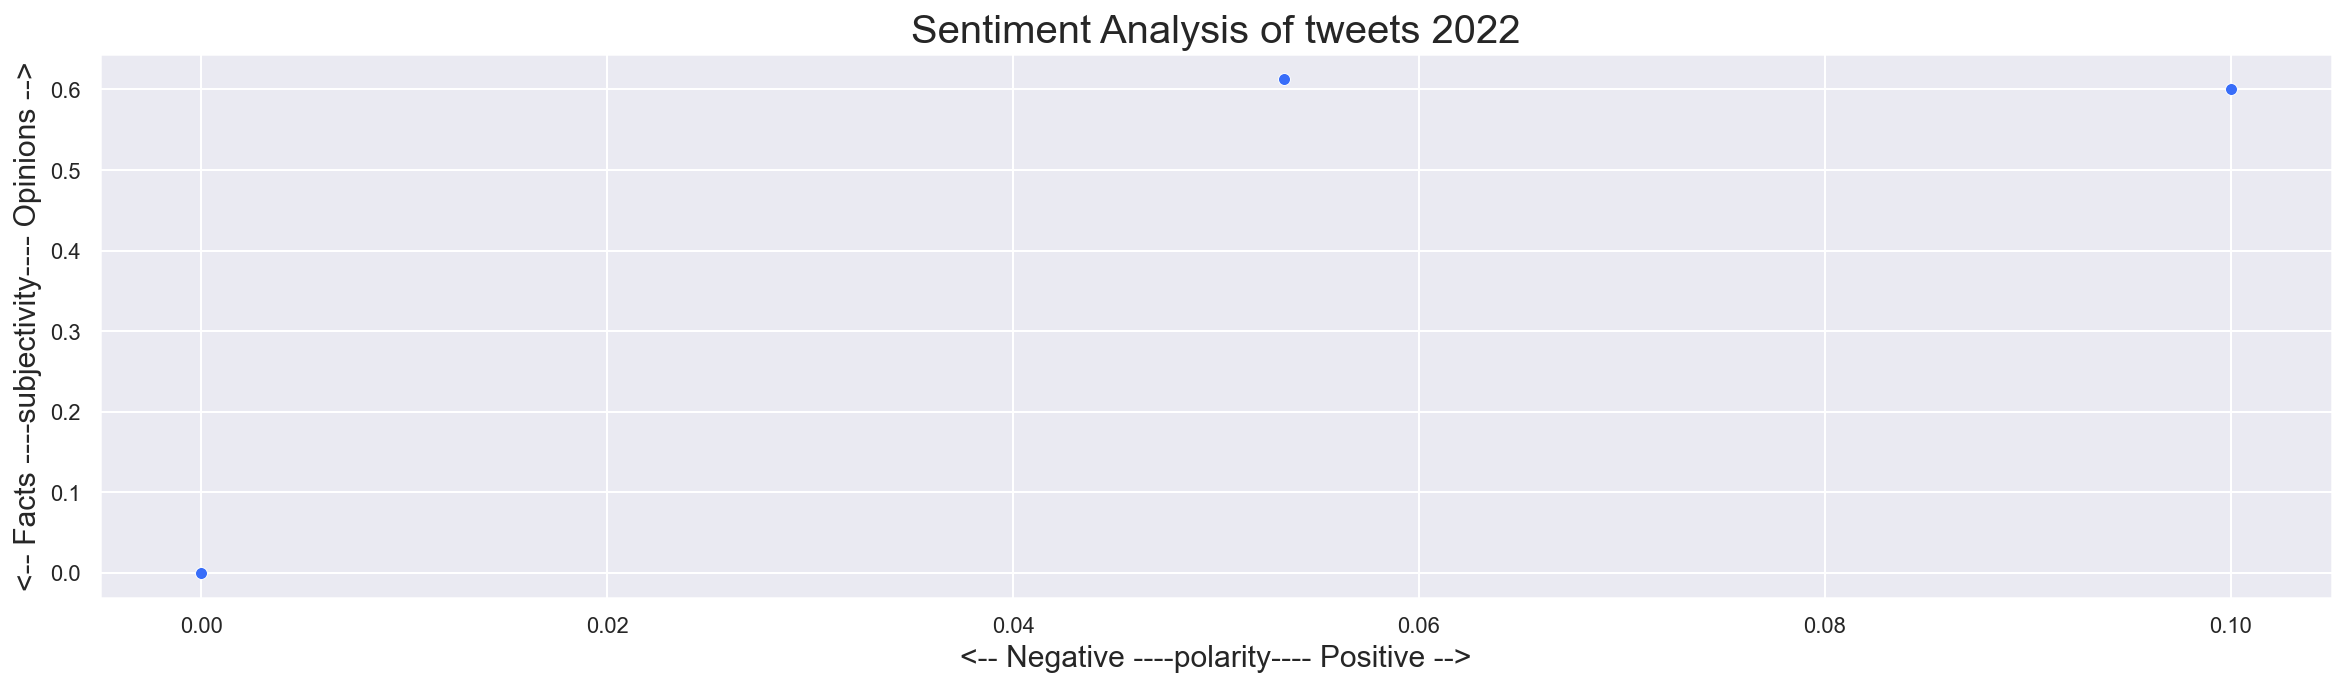

In [29]:
#set to seaborn
sns.set()
#palette
sns.set_palette('rainbow');
#plot size
plt.figure(figsize=(20, 5));  

sns.scatterplot(data=df_tweets, x="polarity", y="subjectivity")

plt.title("Sentiment Analysis of tweets 2022", fontsize=20);
plt.xlabel('<-- Negative ----polarity---- Positive -->', fontsize=15);
plt.ylabel('<-- Facts ----subjectivity---- Opinions -->', fontsize=15);

plt.show();

### Document term matrix

https://analyticsindiamag.com/a-guide-to-term-document-matrix-with-its-implementation-in-r-and-python/

In [30]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words="english")
data_cv = cv.fit_transform(df_tweets['tweet_clean'])
data_dtm =pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())

# Pickle it for later use
import pickle
pickle.dump(cv, open("../data/cv_stop.pkl", "wb"))

data_dtm

,agree,agribusiness,awake,bear,ccgt,consumers,cost,costs,don,electricity,...,profits,report,rise,rising,store,superprofits,surging,used,wholesale,wind
0,0,1,1,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
1,1,0,0,1,1,1,1,1,0,1,...,1,0,0,0,0,1,0,0,1,1
2,0,0,0,0,0,0,0,1,1,0,...,0,0,1,1,1,0,0,1,0,0


In [31]:
#Gensism Python framework for fast Vector Space Modelling
from gensim import matutils, models
#ndustrial-strength Natural Language Processing (NLP) in Python
import scipy.sparse

### Topic modelling

In [32]:
# One of the required inputs is a term-document matrix
data_dtm = data_dtm.transpose()
data_dtm.head()

,0,1,2
agree,0,1,0
agribusiness,1,0,0
awake,1,0,0
bear,0,1,0
ccgt,0,1,0


In [33]:
# turn term matrix into a sparse matrix
sparse_counts = scipy.sparse.csr_matrix(data_dtm)
corpus = matutils.Sparse2Corpus(sparse_counts)

In [34]:
# Gensim also requires dictionary of the all terms and their respective location in the term-document matrix
#cv = pickle.load(open("../data/cv_stop.pkl", "rb"))

In [35]:
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

In [36]:
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=10)
lda.print_topics()

[(0,
  '0.051*"costs" + 0.051*"farm" + 0.030*"production" + 0.030*"consumers" + 0.030*"agree" + 0.030*"electricity" + 0.030*"wind" + 0.030*"profits" + 0.030*"ccgt" + 0.030*"making"'),
 (1,
  '0.051*"prices" + 0.051*"farm" + 0.051*"costs" + 0.051*"inevitable" + 0.051*"store" + 0.051*"know" + 0.051*"used" + 0.051*"level" + 0.051*"rise" + 0.051*"rising"')]

In [37]:
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=3, passes=10)
lda.print_topics()

[(0,
  '0.055*"farm" + 0.055*"costs" + 0.055*"surging" + 0.055*"farmers" + 0.055*"agribusiness" + 0.055*"report" + 0.055*"awake" + 0.055*"ifac" + 0.055*"night" + 0.055*"input"'),
 (1,
  '0.055*"prices" + 0.055*"costs" + 0.055*"farm" + 0.032*"inevitable" + 0.032*"rise" + 0.032*"used" + 0.032*"know" + 0.032*"don" + 0.032*"level" + 0.032*"store"'),
 (2,
  '0.027*"costs" + 0.027*"keeping" + 0.027*"irish" + 0.027*"input" + 0.027*"night" + 0.027*"ifac" + 0.027*"awake" + 0.027*"report" + 0.027*"farm" + 0.027*"agribusiness"')]

In [38]:
# LDA for num_topics = 4
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=4, passes=10)
lda.print_topics()

[(0,
  '0.027*"high" + 0.027*"profits" + 0.027*"massive" + 0.027*"making" + 0.027*"low" + 0.027*"cost" + 0.027*"bear" + 0.027*"wind" + 0.027*"electricity" + 0.027*"wholesale"'),
 (1,
  '0.027*"costs" + 0.027*"farm" + 0.027*"rising" + 0.027*"don" + 0.027*"store" + 0.027*"know" + 0.027*"used" + 0.027*"rise" + 0.027*"level" + 0.027*"inevitable"'),
 (2,
  '0.057*"prices" + 0.057*"costs" + 0.057*"farm" + 0.032*"rise" + 0.032*"know" + 0.032*"level" + 0.032*"don" + 0.032*"inevitable" + 0.032*"store" + 0.032*"used"'),
 (3,
  '0.059*"farm" + 0.059*"costs" + 0.059*"input" + 0.059*"report" + 0.059*"ifac" + 0.059*"surging" + 0.059*"farmers" + 0.059*"irish" + 0.059*"keeping" + 0.059*"agribusiness"')]

### Topic Modeling - Attempt #2 (Nouns Only)

In [39]:
# Let's create a function to pull out nouns from a string of text
from nltk import word_tokenize, pos_tag

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [40]:
# Apply the nouns function to the transcripts to filter only on nouns
df_tweets['data_nouns'] = pd.DataFrame(df_tweets.tweet_clean.apply(nouns))
df_tweets

,Unnamed: 0,Datetime,Tweet Id,Text,word_count,char_count,stopwords,hashtag,tweet_clean,polarity,subjectivity,data_nouns
0,0,2022-04-27,1519235527324712960,‘Surging input costs are keeping #farmers awak...,17,139,2,3,‘surging input costs keeping farmers awake nig...,0.000000,0.000000,‘ input costs farmers night ’ ifac farm report...
1,1,2022-04-02,1510305024081117190,@jerwaugh @youngsiward Would you not agree tha...,44,259,20,0,would agree owned wind farm ccgt would making ...,0.053333,0.613333,farm ccgt profits prices production cost elect...
2,2,2022-02-27,1497968564069879813,@libraryturner @lidl_ireland Don’t get used to...,28,169,9,0,don’t get used costs rising much farm level it...,0.100000,0.600000,don ’ t costs farm level prices rise


In [41]:
df_tweets.data_nouns

0    ‘ input costs farmers night ’ ifac farm report...
1    farm ccgt profits prices production cost elect...
2                 don ’ t costs farm level prices rise
Name: data_nouns, dtype: object

In [44]:
# Create a new document-term matrix using only nouns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer

# Re-add the additional stop words since we are recreating the document-term matrix
add_stop_words = ['like', 'im', 'know', 'just', 'dont', 'thats', 'right', 'people',
                  'youre', 'got', 'gonna', 'time', 'think', 'yeah', 'said', 'amp']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate a document-term matrix with only nouns
cvn = CountVectorizer(stop_words=stop_words)
data_cvn = cvn.fit_transform(df_tweets.data_nouns)
data_dtmn = pd.DataFrame(data_cvn.toarray(), columns=cvn.get_feature_names())

data_dtmn

,agribusiness,ccgt,consumers,cost,costs,don,electricity,farm,farmers,ifac,input,level,night,prices,production,profits,report,rise,superprofits
0,1,0,0,0,1,0,0,1,1,1,1,0,1,0,0,0,1,0,0
1,0,1,1,1,1,0,1,1,0,0,0,0,0,1,1,1,0,0,1
2,0,0,0,0,1,1,0,1,0,0,0,1,0,1,0,0,0,1,0


In [45]:
# Create the gensim corpus
corpusn = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmn.transpose()))

# Create the vocabulary dictionary
id2wordn = dict((v, k) for k, v in cvn.vocabulary_.items())

In [46]:
# Let's start with 2 topics
ldan = models.LdaModel(corpus=corpusn, num_topics=2, id2word=id2wordn, passes=10)
ldan.print_topics()

[(0,
  '0.098*"prices" + 0.098*"costs" + 0.098*"farm" + 0.059*"ccgt" + 0.059*"production" + 0.059*"electricity" + 0.059*"profits" + 0.059*"cost" + 0.059*"consumers" + 0.059*"superprofits"'),
 (1,
  '0.086*"farm" + 0.086*"costs" + 0.085*"agribusiness" + 0.085*"farmers" + 0.085*"ifac" + 0.085*"input" + 0.085*"night" + 0.085*"report" + 0.029*"rise" + 0.029*"don"')]

In [47]:
# Let's try topics = 3
ldan = models.LdaModel(corpus=corpusn, num_topics=3, id2word=id2wordn, passes=10)
ldan.print_topics()

[(0,
  '0.115*"farm" + 0.115*"costs" + 0.066*"ifac" + 0.066*"agribusiness" + 0.066*"night" + 0.066*"input" + 0.066*"farmers" + 0.066*"report" + 0.066*"don" + 0.066*"rise"'),
 (1,
  '0.082*"prices" + 0.082*"costs" + 0.082*"farm" + 0.082*"production" + 0.082*"electricity" + 0.082*"consumers" + 0.082*"cost" + 0.082*"profits" + 0.082*"superprofits" + 0.082*"ccgt"'),
 (2,
  '0.053*"prices" + 0.053*"farm" + 0.053*"costs" + 0.053*"level" + 0.053*"rise" + 0.053*"don" + 0.053*"report" + 0.053*"farmers" + 0.053*"agribusiness" + 0.053*"input"')]

In [48]:
# Let's try 4 topics
ldan = models.LdaModel(corpus=corpusn, num_topics=4, id2word=id2wordn, passes=10)
ldan.print_topics()

[(0,
  '0.085*"prices" + 0.085*"consumers" + 0.085*"electricity" + 0.085*"production" + 0.085*"profits" + 0.085*"superprofits" + 0.085*"cost" + 0.085*"farm" + 0.085*"ccgt" + 0.085*"costs"'),
 (1,
  '0.053*"prices" + 0.053*"costs" + 0.053*"farm" + 0.053*"level" + 0.053*"don" + 0.053*"rise" + 0.053*"farmers" + 0.053*"night" + 0.053*"agribusiness" + 0.053*"input"'),
 (2,
  '0.120*"costs" + 0.120*"farm" + 0.067*"agribusiness" + 0.067*"input" + 0.067*"ifac" + 0.067*"report" + 0.067*"night" + 0.067*"farmers" + 0.067*"rise" + 0.067*"don"'),
 (3,
  '0.053*"costs" + 0.053*"prices" + 0.053*"farm" + 0.053*"ccgt" + 0.053*"profits" + 0.053*"cost" + 0.053*"superprofits" + 0.053*"production" + 0.053*"electricity" + 0.053*"consumers"')]

### Topic Modeling - Attempt #3 (Nouns and Adjectives)

In [50]:
# Let's create a function to pull out nouns from a string of text
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [51]:
# Apply the nouns function to the transcripts to filter only on nouns
df_tweets['data_nouns_adj'] = pd.DataFrame(df_tweets.tweet_clean.apply(nouns_adj))

In [52]:
# Create a new document-term matrix using only nouns and adjectives, also remove common words with max_df
cvna = CountVectorizer(stop_words=stop_words, max_df=.8)
data_cvna = cvna.fit_transform(df_tweets.data_nouns_adj)
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())

data_dtmna

,agribusiness,ccgt,consumers,cost,don,electricity,farmers,high,ifac,inevitable,...,low,massive,night,prices,production,profits,report,rise,superprofits,wholesale
0,1,0,0,0,0,0,1,0,1,0,...,0,0,1,0,0,0,1,0,0,0
1,0,1,1,1,0,1,0,1,0,0,...,1,1,0,1,1,1,0,0,1,1
2,0,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0


In [53]:
# Create the gensim corpus
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))

# Create the vocabulary dictionary
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())


In [54]:
# Let's start with 2 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=2, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.064*"input" + 0.064*"report" + 0.064*"irish" + 0.064*"ifac" + 0.064*"night" + 0.064*"farmers" + 0.064*"agribusiness" + 0.064*"inevitable" + 0.064*"don" + 0.064*"rise"'),
 (1,
  '0.065*"prices" + 0.064*"cost" + 0.064*"ccgt" + 0.064*"massive" + 0.064*"high" + 0.064*"profits" + 0.064*"electricity" + 0.064*"low" + 0.064*"wholesale" + 0.064*"superprofits"')]

In [55]:
# Let's try 3 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=3, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.105*"prices" + 0.105*"rise" + 0.105*"inevitable" + 0.105*"level" + 0.105*"don" + 0.026*"farmers" + 0.026*"night" + 0.026*"irish" + 0.026*"report" + 0.026*"ifac"'),
 (1,
  '0.068*"prices" + 0.068*"consumers" + 0.068*"electricity" + 0.068*"high" + 0.068*"ccgt" + 0.068*"massive" + 0.068*"low" + 0.068*"profits" + 0.068*"wholesale" + 0.068*"production"'),
 (2,
  '0.091*"agribusiness" + 0.091*"ifac" + 0.091*"input" + 0.091*"irish" + 0.091*"report" + 0.091*"night" + 0.091*"farmers" + 0.023*"prices" + 0.023*"don" + 0.023*"rise"')]

In [56]:
# Let's try 4 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=4, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.044*"prices" + 0.043*"rise" + 0.043*"production" + 0.043*"inevitable" + 0.043*"level" + 0.043*"don" + 0.043*"superprofits" + 0.043*"high" + 0.043*"low" + 0.043*"agribusiness"'),
 (1,
  '0.044*"prices" + 0.043*"rise" + 0.043*"inevitable" + 0.043*"don" + 0.043*"level" + 0.043*"agribusiness" + 0.043*"ifac" + 0.043*"night" + 0.043*"irish" + 0.043*"input"'),
 (2,
  '0.071*"prices" + 0.070*"profits" + 0.070*"ccgt" + 0.070*"electricity" + 0.070*"cost" + 0.070*"wholesale" + 0.070*"low" + 0.070*"consumers" + 0.070*"massive" + 0.070*"high"'),
 (3,
  '0.070*"farmers" + 0.070*"irish" + 0.070*"report" + 0.070*"input" + 0.070*"night" + 0.070*"ifac" + 0.070*"agribusiness" + 0.070*"don" + 0.070*"level" + 0.070*"inevitable"')]

### Identify Topics in Each Document

In [57]:
# final LDA model (for now)
ldana = models.LdaModel(corpus=corpusna, num_topics=4, id2word=id2wordna, passes=80)
ldana.print_topics()

[(0,
  '0.098*"ifac" + 0.098*"irish" + 0.098*"report" + 0.098*"night" + 0.098*"input" + 0.098*"agribusiness" + 0.098*"farmers" + 0.020*"prices" + 0.020*"inevitable" + 0.020*"rise"'),
 (1,
  '0.070*"high" + 0.070*"superprofits" + 0.070*"massive" + 0.070*"low" + 0.070*"ccgt" + 0.070*"wholesale" + 0.070*"profits" + 0.070*"consumers" + 0.070*"cost" + 0.070*"electricity"'),
 (2,
  '0.043*"prices" + 0.043*"inevitable" + 0.043*"rise" + 0.043*"don" + 0.043*"level" + 0.043*"irish" + 0.043*"report" + 0.043*"night" + 0.043*"input" + 0.043*"agribusiness"'),
 (3,
  '0.116*"prices" + 0.116*"inevitable" + 0.116*"rise" + 0.116*"don" + 0.116*"level" + 0.023*"irish" + 0.023*"report" + 0.023*"night" + 0.023*"input" + 0.023*"agribusiness"')]